In [ ]:
!pip install kaggle

In [ ]:
# This authenticates with Kaggle using the api key you put in your google drive
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [ ]:
!kaggle competitions download --force -c ashrae-energy-prediction

  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 17.3MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 83.6MB/s]
 95% 84.0M/88.4M [00:00<00:00, 64.2MB/s]
100% 88.4M/88.4M [00:00<00:00, 95.9MB/s]
 97% 116M/120M [00:01<00:00, 74.8MB/s]
100% 120M/120M [00:01<00:00, 72.1MB/s]
 97% 161M/167M [00:01<00:00, 91.6MB/s]
100% 167M/167M [00:01<00:00, 100MB/s] 
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 180MB/s]


In [ ]:
!unzip /content/weather_test.csv.zip
!unzip /content/weather_train.csv.zip
!unzip /content/test.csv.zip 
!unzip /content/train.csv.zip
!unzip /content/sample_submission.csv.zip

Archive:  /content/weather_test.csv.zip
  inflating: weather_test.csv        
Archive:  /content/weather_train.csv.zip
  inflating: weather_train.csv       
Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   


**Data Exploration**

In [ ]:
import pandas as pd
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
weather_test_df = pd.read_csv('/content/weather_test.csv')
weather_train_df = pd.read_csv('/content/weather_train.csv')
build_df = pd.read_csv('/content/building_metadata.csv')
sample_df = pd.read_csv('/content/sample_submission.csv')

In [ ]:
##function to reduce mem s
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
##memory use reduction
import numpy as np
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
build_df = reduce_mem_usage(build_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [ ]:
train_df.head(20)

In [ ]:
weather_train_df.head(10)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6
5,0,2017-01-01 05:00:00,15.6,2.0,12.8,0.0,1022.1,130.0,2.1
6,0,2017-01-01 06:00:00,15.0,0.0,12.8,0.0,1021.7,150.0,1.5
7,0,2017-01-01 07:00:00,15.0,2.0,13.3,0.0,1021.6,0.0,0.0
8,0,2017-01-01 08:00:00,13.3,0.0,12.2,0.0,1021.4,0.0,0.0
9,0,2017-01-01 09:00:00,12.2,4.0,11.7,0.0,1021.4,0.0,0.0


In [ ]:
train_df.describe()


,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [ ]:
test_df.describe()


,row_id,building_id,meter
count,4.169760e+07,4.169760e+07,4.169760e+07
mean,2.084880e+07,8.075824e+02,6.642857e-01
std,1.203706e+07,4.297680e+02,9.278067e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.042440e+07,4.047500e+02,0.000000e+00
50%,2.084880e+07,9.000000e+02,0.000000e+00
75%,3.127320e+07,1.194250e+03,1.000000e+00
max,4.169760e+07,1.448000e+03,3.000000e+00


In [ ]:
weather_train_df.describe()


,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.000000,139660.000000,89484.000000,129155.000000,133505.000000,139469.000000
mean,7.478977,14.418106,2.149306,7.350158,0.983047,1016.158038,180.526632,3.560527
std,4.604744,10.626595,2.599150,9.790235,8.463678,7.629684,111.523629,2.335874
min,0.000000,-28.900000,0.000000,-35.000000,-1.000000,968.200000,0.000000,0.000000
25%,3.000000,7.200000,0.000000,0.600000,0.000000,1011.800000,80.000000,2.100000
50%,7.000000,15.000000,2.000000,8.300000,0.000000,1016.400000,190.000000,3.100000
75%,11.000000,22.200000,4.000000,14.400000,0.000000,1020.800000,280.000000,5.000000
max,15.000000,47.200000,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000


In [ ]:
weather_test_df.describe()


,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,277243.000000,277139.000000,136795.000000,276916.000000,181655.000000,255978.000000,264873.000000,276783.000000
mean,7.484654,14.276863,2.187317,7.487658,1.095395,1016.195762,180.426023,3.548873
std,4.616959,10.741605,2.620627,10.153973,9.163511,7.940392,110.456872,2.317184
min,0.000000,-28.100000,0.000000,-31.600000,-1.000000,972.000000,0.000000,0.000000
25%,3.000000,7.200000,0.000000,0.600000,0.000000,1011.600000,80.000000,2.100000
50%,7.000000,15.000000,2.000000,8.400000,0.000000,1016.300000,190.000000,3.100000
75%,12.000000,22.200000,4.000000,15.000000,0.000000,1020.800000,280.000000,4.600000
max,15.000000,48.300000,9.000000,26.700000,597.000000,1050.100000,360.000000,24.200000


In [ ]:
building_df.describe()


,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,92111.776398,1967.957037,3.740845
std,5.003432,418.434583,110769.950997,31.054030,3.333683
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


In [ ]:
building_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


**Data Processing**

In [ ]:
build_df = building_df
build_df.primary_use.unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

**Codes for Combined Data**

In [ ]:
#feature engineering before join

from datetime import datetime
weather_train_df['timestamp2'] = weather_train_df['timestamp'].astype('datetime64[ns]')

#Create the moving average of last few hours
weather_train_df.sort_values(by=['site_id', 'timestamp2'])
weather_train_df['avg_air_temp_last_5hr'] = weather_train_df.groupby('site_id')['air_temperature'].transform(lambda x: x.rolling(5, 1).mean())
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,timestamp2,avg_air_temp_last_5hr,date,avg_air_temperature_per_day,max,min,diff_air_temperature_per_day
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,2016-01-01 00:00:00,25.000000,2016-01-01,23.3375,28.3,18.9,9.4
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5,2016-01-01 01:00:00,24.700000,2016-01-01,23.3375,28.3,18.9,9.4
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,2016-01-01 02:00:00,24.066667,2016-01-01,23.3375,28.3,18.9,9.4
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,2016-01-01 03:00:00,23.325000,2016-01-01,23.3375,28.3,18.9,9.4
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,2016-01-01 04:00:00,22.660000,2016-01-01,23.3375,28.3,18.9,9.4


In [ ]:
# Create daily average
weather_train_df['date'] = weather_train_df['timestamp2'].dt.date
#weather_train_df_daily_avg_airtemp = weather_train_df.groupby(['site_id','date'])['air_temperature'].mean().reset_index()
weather_train_df_daily_avg_airtemp = weather_train_df.groupby(['site_id','date'])['air_temperature'].agg(['mean', 'max','min'])
weather_train_df_daily_avg_airtemp['diff'] = weather_train_df_daily_avg_airtemp['max']-weather_train_df_daily_avg_airtemp['min']
weather_train_df_daily_avg_airtemp = weather_train_df_daily_avg_airtemp.rename(columns={'mean': 'avg_daily_temp', 'diff': 'diff_daily_temp', 'max': 'max_daily_temp', 'min': 'min_daily_temp'})
weather_train_df = pd.merge(weather_train_df, weather_train_df_daily_avg_airtemp, how='left', left_on=['site_id','date'], right_on=['site_id','date'])
#clean the merged dataframe
weather_train_df.drop(columns=['timestamp2', 'date'])
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,timestamp2,avg_air_temp_last_5hr,date,avg_air_temperature_per_day,max,min,diff_air_temperature_per_day,avg_daily_temp,max_daily_temp,min_daily_temp,diff_daily_temp
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,2016-01-01 00:00:00,25.000000,2016-01-01,23.3375,28.3,18.9,9.4,23.3375,28.3,18.9,9.4
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5,2016-01-01 01:00:00,24.700000,2016-01-01,23.3375,28.3,18.9,9.4,23.3375,28.3,18.9,9.4
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,2016-01-01 02:00:00,24.066667,2016-01-01,23.3375,28.3,18.9,9.4,23.3375,28.3,18.9,9.4
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,2016-01-01 03:00:00,23.325000,2016-01-01,23.3375,28.3,18.9,9.4,23.3375,28.3,18.9,9.4
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,2016-01-01 04:00:00,22.660000,2016-01-01,23.3375,28.3,18.9,9.4,23.3375,28.3,18.9,9.4


In [ ]:
#join
df=train_df.join(build_df.set_index("building_id"), on="building_id")
df = pd.merge(df, weather_train_df,  how='left', left_on=['site_id','timestamp'], right_on = ['site_id','timestamp'])
#correct the site_id=0 data entry issues
df.loc[(df['site_id'] == 0) & (df['meter'] == 0), 'meter_reading'] = df[(df['site_id'] == 0) & (df['meter'] == 0)]['meter_reading'] * 0.2931
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   building_id         int16  
 1   meter               int8   
 2   timestamp           object 
 3   meter_reading       float32
 4   site_id             int8   
 5   primary_use         object 
 6   square_feet         int32  
 7   year_built          float16
 8   floor_count         float16
 9   air_temperature     float16
 10  cloud_coverage      float16
 11  dew_temperature     float16
 12  precip_depth_1_hr   float16
 13  sea_level_pressure  float16
 14  wind_direction      float16
 15  wind_speed          float16
dtypes: float16(9), float32(1), int16(1), int32(1), int8(2), object(2)
memory usage: 1.0+ GB


In [ ]:
# get the energy of each building primary use
primary_use_energy = df.groupby(['primary_use'])['meter_reading'].sum().reset_index()

primary_use_energy

,primary_use,meter_reading
0,Education,3.743959e+10
1,Entertainment/public assembly,1.073300e+09
2,Food sales and service,3.478696e+07
3,Healthcare,2.943511e+08
4,Lodging/residential,6.003741e+08
5,Manufacturing/industrial,3.594097e+07
6,Office,2.313915e+09
7,Other,3.359711e+07
8,Parking,3.621422e+07
9,Public services,4.792894e+08


**Plotting**

plot - meter reading

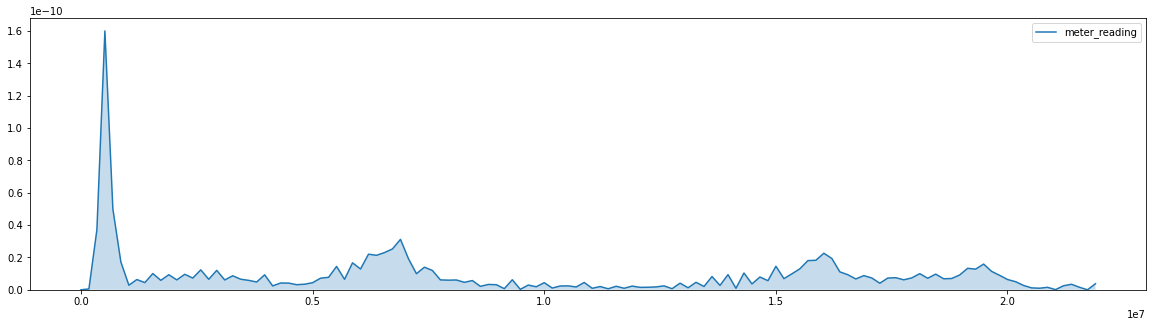

In [ ]:
import seaborn
plt.figure(figsize=(20,5))
# bw is the bandwidth - decrease it to fit the data tighter
seaborn.kdeplot(df.meter_reading, bw=0.5, shade=True)
plt.show()

In [ ]:
df.meter_reading.describe()

count    2.021610e+07
mean     1.987455e+03
std      1.532159e+05
min      0.000000e+00
25%      1.797590e+01
50%      7.509000e+01
75%      2.526000e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

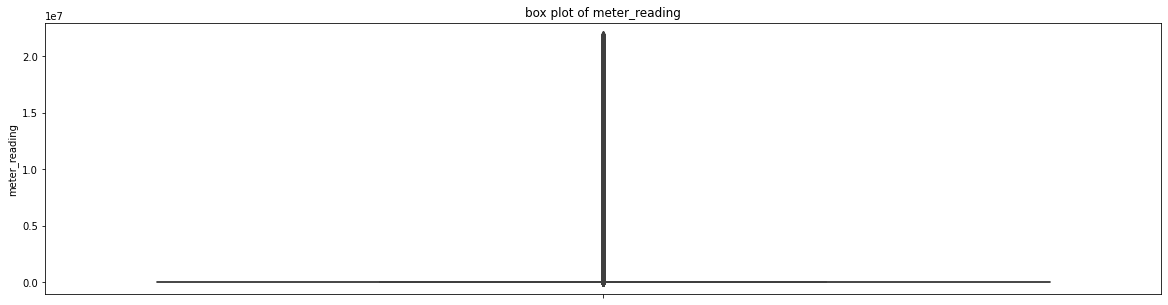

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
seaborn.boxplot(y="meter_reading", data=df)
plt.title("box plot of meter_reading")
plt.show()

plot - meter type

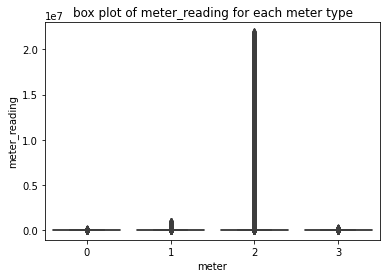

In [ ]:
import seaborn
import matplotlib.pyplot as plt
seaborn.boxplot(x="meter", y="meter_reading", data=df)
plt.title("box plot of meter_reading for each meter type")
plt.show()

plot - hour

In [ ]:
from datetime import datetime
df['timestamp'] = df['timestamp'].astype('datetime64[ns]') 
df['hour'] = df['timestamp'].dt.hour



In [ ]:
temp_df_2 = df.groupby(['hour'])['meter_reading'].agg(['sum']).reset_index()
temp_df_2

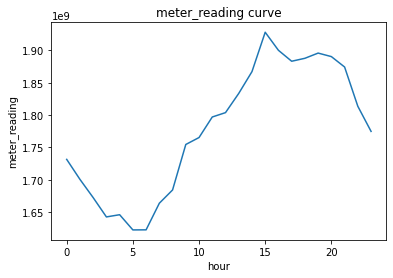

In [ ]:
plt.figure()
plt.plot(temp_df_2['hour'], temp_df_2["sum"] )
plt.title("meter_reading curve")
plt.xlabel("hour")
plt.ylabel("meter_reading")
plt.show()

plot - hour - meter type

In [ ]:
from datetime import datetime
df['timestamp'] = df['timestamp'].astype('datetime64[ns]') 
df['hour'] = df['timestamp'].dt.hour

In [ ]:
temp_df = df.loc[df['meter']==3, :]
temp_df_2 = temp_df.groupby(['hour'])['meter_reading'].agg(['sum']).reset_index()
#temp_df_2

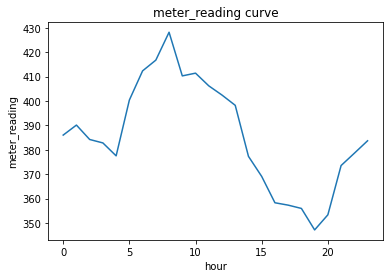

In [ ]:
plt.figure()
plt.plot(temp_df_2['hour'], temp_df_2["sum"] )
plt.title("meter_reading curve")
plt.xlabel("hour")
plt.ylabel("meter_reading")
plt.show()

plot - month

In [ ]:
from datetime import datetime
df['timestamp'] = df['timestamp'].astype('datetime64[ns]') 
df['month'] = df['timestamp'].dt.month

In [ ]:
temp_df = df.loc[df['meter']==3, :]
#temp_df_2 = df.groupby(['month'])['meter_reading'].agg(['mean']).reset_index()
temp_df_2 = temp_df.groupby(['month'])['meter_reading'].agg(['mean']).reset_index()

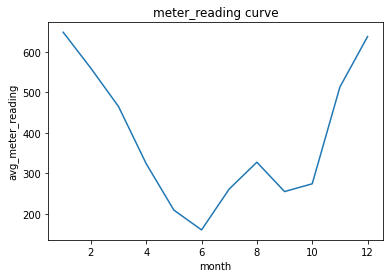

In [ ]:
plt.figure()
plt.plot(temp_df_2['month'], temp_df_2["mean"] )
plt.title("meter_reading curve")
plt.xlabel("month")
plt.ylabel("avg_meter_reading")
plt.show()

plot - air temperature

In [ ]:
temp_df = df.loc[df['air_temperature'].notnull()]
temp_df["air_temperature_int"] = temp_df["air_temperature"].astype(int) # for better visualization, air temperature is set to integer
temp_df_2 = temp_df.groupby(['air_temperature_int'])['meter_reading'].agg(['mean']).reset_index() # use mean air temperature because the observation of air temperature is not even

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


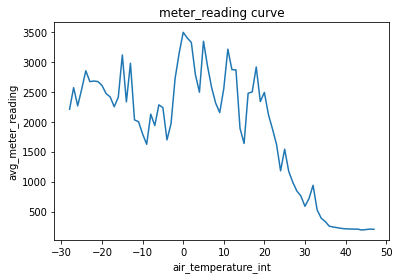

In [ ]:
plt.figure()
plt.plot(temp_df_2['air_temperature_int'], temp_df_2["mean"] )
plt.title("meter_reading curve")
plt.xlabel("air_temperature_int")
plt.ylabel("avg_meter_reading")
plt.show()

plot - other weather var

In [ ]:
variable_list = ("cloud_coverage", "dew_temperature", "precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


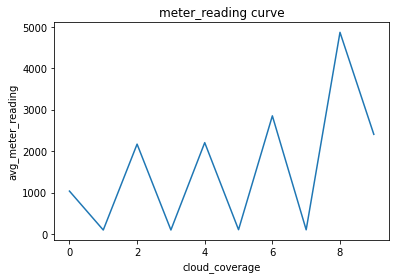

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


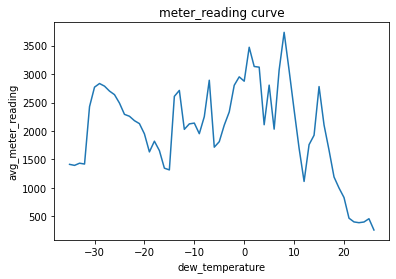

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


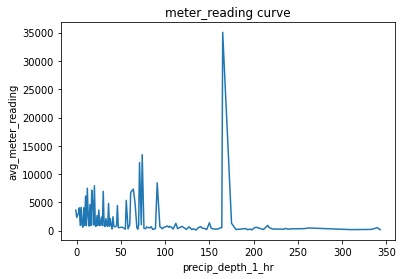

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


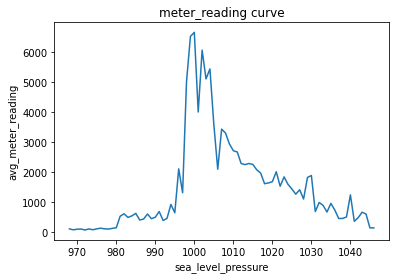

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


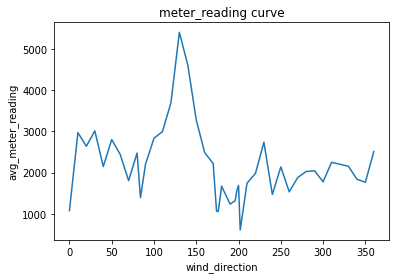

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


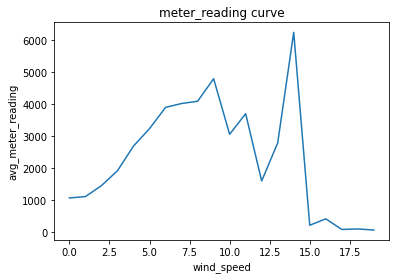

In [ ]:
for one_var in variable_list:
  temp_df = df.loc[df[one_var].notnull()]
  temp_df[one_var] = temp_df[one_var].astype(int) # for better visualization, air temperature is set to integer
  temp_df_2 = temp_df.groupby([one_var])['meter_reading'].agg(['mean']).reset_index() # use mean air temperature because the observation of air temperature is not even
  plt.figure()
  plt.plot(temp_df_2[one_var], temp_df_2["mean"] )
  plt.title("meter_reading curve")
  plt.xlabel(one_var)
  plt.ylabel("avg_meter_reading")
  plt.show()

plot - square feet

In [ ]:
df['square_feet'].min()

283

In [ ]:
temp_df = df.loc[df['square_feet'].notnull()]
temp_df['square_feet_thousands'] = temp_df['square_feet'] / 10000
temp_df['square_feet_thousands'] = temp_df['square_feet_thousands'].astype(int)
temp_df_2 = temp_df.groupby(['square_feet_thousands'])['meter_reading'].agg(['mean']).reset_index() 

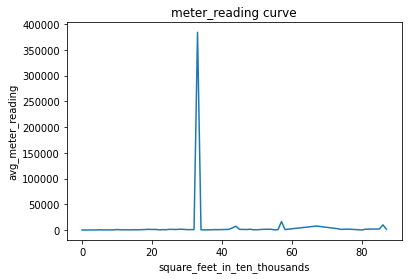

In [ ]:
plt.figure()
plt.plot(temp_df_2['square_feet_thousands'], temp_df_2["mean"] )
plt.title("meter_reading curve")
plt.xlabel("square_feet_in_ten_thousands")
plt.ylabel("avg_meter_reading")
plt.show()

investigate what buildings have high meter_reading

In [ ]:
temp_df_2.sort_values(by=['mean'])

,square_feet_thousands,mean
0,0,31.198277
1,1,63.344677
4,4,87.583466
2,2,102.571144
3,3,122.094719
...,...,...
40,44,7314.076660
53,67,7722.649414
60,86,10058.896484
51,57,16425.283203


In [ ]:
#temp_df = df.loc[df['meter_reading']>50000, :]
temp_df = temp_df.loc[temp_df['square_feet_thousands']==33, :]
temp_df_2 = temp_df[["building_id", "primary_use", "meter", "year_built", "square_feet"]]
temp_df_2.drop_duplicates()

,building_id,primary_use,meter,year_built,square_feet
966,792,Education,1,1938.0,333681
967,792,Education,2,1938.0,333681
1236,945,Office,0,NaN,332447
1237,945,Office,1,NaN,332447
1238,945,Office,2,NaN,332447
1533,1099,Education,0,NaN,332884
1534,1099,Education,2,NaN,332884
1603,1139,Office,0,NaN,336650
1604,1139,Office,1,NaN,336650
1605,1139,Office,2,NaN,336650


plot - year built

In [ ]:
df['year_built'].max()

2017.0

In [ ]:
temp_df = df.loc[df['year_built'].notnull()]
temp_df['year_built'] = temp_df['year_built'].astype(int)
temp_df_2 = temp_df.groupby(['year_built'])['meter_reading'].agg(['mean']).reset_index() 

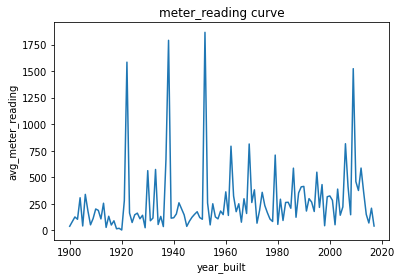

In [ ]:
plt.figure()
plt.plot(temp_df_2['year_built'], temp_df_2["mean"] )
plt.title("meter_reading curve")
plt.xlabel("year_built")
plt.ylabel("avg_meter_reading")
plt.show()

investigate what year of built have high meter_reading

In [ ]:
temp_df_2.sort_values(by=['mean'])

,year_built,mean
19,1920,3.660648
17,1918,15.217703
18,1919,19.888433
28,1929,25.133806
13,1914,28.289911
...,...,...
104,2006,816.496765
107,2009,1523.678467
21,1922,1584.866333
37,1938,1790.506470


In [ ]:
temp_df = temp_df.loc[(df['year_built']==1952) | (df['year_built']==1938) | (df['year_built']==1922) | (df['year_built']==2009), :]
temp_df_2 = temp_df[["building_id", "primary_use", "meter", "year_built", "square_feet"]]
temp_df_2.drop_duplicates()

,building_id,primary_use,meter,year_built,square_feet
74,76,Education,0,2009,128887
180,166,Lodging/residential,0,2009,553210
181,166,Lodging/residential,1,2009,553210
182,166,Lodging/residential,3,2009,553210
525,365,Healthcare,0,1922,819577
547,387,Education,0,2009,104200
744,589,Education,0,1952,305268
796,648,Education,0,2009,154706
966,792,Education,1,1938,333681
967,792,Education,2,1938,333681


Plot - building id
(to find outlier)

In [ ]:
temp_df_2 = df.groupby(['building_id'])['meter_reading'].agg(['mean']).reset_index()

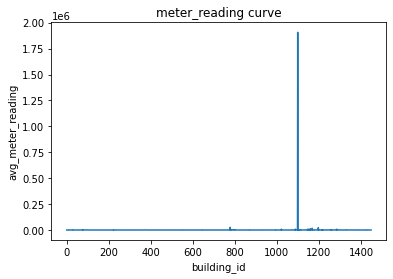

In [ ]:
plt.figure()
plt.plot(temp_df_2['building_id'], temp_df_2["mean"] )
plt.title("meter_reading curve")
plt.xlabel("building_id")
plt.ylabel("avg_meter_reading")
plt.show()

In [ ]:
temp_df_2.sort_values(by=['mean'])

,building_id,mean
740,740,3.999772e-04
817,817,1.710708e-01
815,815,1.752872e-01
636,636,1.844866e-01
637,637,2.000814e-01
...,...,...
1159,1159,1.199166e+04
1168,1168,1.642528e+04
1197,1197,2.222224e+04
778,778,2.612168e+04


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 <a list of 16 Text major ticklabel objects>)

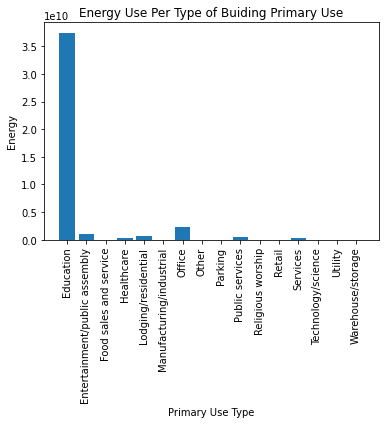

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.bar(primary_use_energy.primary_use, primary_use_energy.meter_reading)
plt.title("Energy Use Per Type of Buiding Primary Use")
plt.xlabel("Primary Use Type")
plt.ylabel("Energy")
plt.xticks(rotation='vertical')
#plt.yticks(0, 90, 10)

In [ ]:
# get the energy of each building primary use, colored by energy type
energy_0 = df.loc[df['meter']==0,:]
primary_use_energy_0 = energy_0.groupby(['primary_use'])['meter_reading'].sum().reset_index()
energy_1 = df.loc[df['meter']==1,:]
primary_use_energy_1 = energy_1.groupby(['primary_use'])['meter_reading'].sum().reset_index()
energy_2 = df.loc[df['meter']==2,:]
primary_use_energy_2 = energy_2.groupby(['primary_use'])['meter_reading'].sum().reset_index()
energy_3 = df.loc[df['meter']==3,:]
primary_use_energy_3 = energy_3.groupby(['primary_use'])['meter_reading'].sum().reset_index()
#primary_use_energy_0.head()

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(primary_use_energy_0.primary_use, primary_use_energy_0.meter_reading, color='blue')
plt.bar(primary_use_energy_1.primary_use, primary_use_energy_1.meter_reading, color='pink')
#plt.bar(primary_use_energy_2.primary_use, primary_use_energy_2.meter_reading, color='green')
plt.bar(primary_use_energy_3.primary_use, primary_use_energy_3.meter_reading, color='red')
plt.title("Energy Use Per Type of Buiding Primary Use - without Energy Type 2: Steam", fontsize=18)
plt.xlabel("Primary Use Type", fontsize=18)
plt.ylabel("Energy", fontsize=18)
plt.xticks(rotation='vertical', fontsize=18)

#colors = {'energy_0_electricity':'blue', 'energy_1_chilledwater':'pink','energy_2_steam':'green','energy_3_hotwater':'red'}         
colors = {'energy_0_electricity':'blue', 'energy_1_chilledwater':'pink','energy_3_hotwater':'red'}      
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

In [ ]:
# plot distribution of meter_reading
df.hist(column='meter_reading', by='meter', bins=25, grid=False, figsize=(20,10), layout=(4,1), sharex=True, color='#86bf91', zorder=2, rwidth=9)

In [ ]:
df.describe()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,avg_air_temp_last_5hr,avg_air_temperature_per_day,max,min,diff_air_temperature_per_day
count,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,8.088455e+06,3.506933e+06,2.011944e+07,1.139074e+07,2.011596e+07,1.646708e+07,1.898443e+07,1.876705e+07,2.007242e+07,2.012500e+07,2.012560e+07,2.012560e+07,2.012560e+07,2.012560e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03,7.992232e+00,1.077830e+05,1.968277e+03,4.184848e+00,1.598795e+01,1.900423e+00,7.747429e+00,7.964155e-01,1.016085e+03,1.730151e+02,3.377525e+00,1.598664e+01,1.598690e+01,2.134792e+01,1.153138e+01,9.816541e+00
std,4.269133e+02,9.309921e-01,1.532356e+05,5.099060e+00,1.171424e+05,3.020815e+01,4.008277e+00,1.094729e+01,2.402909e+00,1.017867e+01,7.468997e+00,7.060539e+00,1.140574e+02,2.265694e+00,1.085915e+01,1.038236e+01,1.110495e+01,1.003535e+01,3.891666e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,1.900000e+03,1.000000e+00,-2.890000e+01,0.000000e+00,-3.500000e+01,-1.000000e+00,9.682000e+02,0.000000e+00,0.000000e+00,-2.840000e+01,-2.492500e+01,-1.940000e+01,-2.890000e+01,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01,3.000000e+00,3.252700e+04,1.951000e+03,1.000000e+00,8.600000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.011600e+03,7.000000e+01,2.100000e+00,8.660000e+00,8.958333e+00,1.390000e+01,5.000000e+00,7.000000e+00
50%,8.950000e+02,0.000000e+00,7.877500e+01,9.000000e+00,7.270900e+04,1.969000e+03,3.000000e+00,1.670000e+01,0.000000e+00,8.900000e+00,0.000000e+00,1.016000e+03,1.800000e+02,3.100000e+00,1.690000e+01,1.710417e+01,2.280000e+01,1.220000e+01,9.500000e+00
75%,1.179000e+03,1.000000e+00,2.679840e+02,1.300000e+01,1.391130e+05,1.993000e+03,6.000000e+00,2.410000e+01,4.000000e+00,1.610000e+01,0.000000e+00,1.020500e+03,2.800000e+02,4.600000e+00,2.418000e+01,2.374583e+01,2.940000e+01,1.940000e+01,1.220000e+01
max,1.448000e+03,3.000000e+00,2.190470e+07,1.500000e+01,8.750000e+05,2.017000e+03,2.600000e+01,4.720000e+01,9.000000e+00,2.610000e+01,3.430000e+02,1.045500e+03,3.600000e+02,1.900000e+01,4.710000e+01,4.018750e+01,4.720000e+01,3.390000e+01,2.500000e+01


In [ ]:
df_outlier = df.loc[df['meter_reading']>100000, :]
df_outlier

In [ ]:
# Feature Engineering 
# Add new column
from datetime import datetime
#df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
#df['timestamp'] = datetime.strptime(df['timestamp'], '%Y-%m-%d %H:%M:%S')
#df['timestamp'] = df['timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df['timestamp'] = df['timestamp'].astype('datetime64[ns]') 
df.head()



,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [ ]:

df['hour'] = df['timestamp'].dt.hour
df['month'] = df['timestamp'].dt.month
df['dayofweek'] = df['timestamp'].dt.weekday
df.head()
df.describe()


,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,month,dayofweek
count,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,8088455.0,3506933.0,2.011944e+07,11390735.0,2.011596e+07,16467077.0,18984431.0,18767052.0,2.007242e+07,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,1.987455e+03,7.992232e+00,1.077830e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.150232e+01,6.578453e+00,3.006958e+00
std,4.269133e+02,9.309921e-01,1.532159e+05,5.099060e+00,1.171424e+05,NaN,0.0,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,0.000000e+00,6.922017e+00,3.436662e+00,1.997191e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,1900.0,1.0,-2.890625e+01,0.0,-3.500000e+01,-1.0,968.0,0.0,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.797590e+01,3.000000e+00,3.252700e+04,1951.0,1.0,8.601562e+00,0.0,0.000000e+00,0.0,1011.5,70.0,2.099609e+00,6.000000e+00,4.000000e+00,1.000000e+00
50%,8.950000e+02,0.000000e+00,7.509000e+01,9.000000e+00,7.270900e+04,1969.0,3.0,1.670312e+01,0.0,8.898438e+00,0.0,1016.0,180.0,3.099609e+00,1.200000e+01,7.000000e+00,3.000000e+00
75%,1.179000e+03,1.000000e+00,2.526000e+02,1.300000e+01,1.391130e+05,1993.0,6.0,2.409375e+01,4.0,1.609375e+01,0.0,1020.5,280.0,4.601562e+00,1.800000e+01,1.000000e+01,5.000000e+00
max,1.448000e+03,3.000000e+00,2.190470e+07,1.500000e+01,8.750000e+05,2017.0,26.0,4.718750e+01,9.0,2.609375e+01,343.0,1046.0,360.0,1.900000e+01,2.300000e+01,1.200000e+01,6.000000e+00


In [ ]:
####
#temporary
df = df.iloc[:200000]
df.describe()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,month
count,200000.000000,200000.000000,2.000000e+05,200000.000000,200000.000000,80570.000000,35001.000000,190542.000000,100787.000000,190542.000000,157202.000000,169405.000000,184330.000000,190542.000000,200000.000000,200000.0
mean,813.480485,0.655965,9.919844e+02,8.161235,107859.600330,1967.205871,4.163624,5.036617,1.600365,-1.578287,0.112085,1018.751753,204.267075,3.487785,10.727115,1.0
std,426.397485,0.932984,3.722619e+04,5.102281,117319.303645,30.061119,4.003277,7.792753,2.384197,7.095880,1.137829,8.535189,118.296486,2.114563,6.764347,0.0
min,0.000000,0.000000,0.000000e+00,0.000000,283.000000,1900.000000,1.000000,-16.700000,0.000000,-20.000000,-1.000000,974.900000,0.000000,0.000000,0.000000,1.0
25%,414.000000,0.000000,1.039000e+01,3.000000,32206.000000,1951.000000,1.000000,-0.700000,0.000000,-6.100000,0.000000,1015.600000,100.000000,2.100000,5.000000,1.0
50%,907.000000,0.000000,5.472000e+01,9.000000,72709.000000,1968.000000,3.000000,5.600000,0.000000,-2.200000,0.000000,1018.600000,240.000000,3.600000,10.000000,1.0
75%,1196.000000,1.000000,1.970673e+02,13.000000,139683.000000,1991.000000,6.000000,9.400000,2.000000,1.100000,0.000000,1022.000000,300.000000,4.600000,16.000000,1.0
max,1448.000000,3.000000,3.577180e+06,15.000000,875000.000000,2017.000000,26.000000,28.300000,8.000000,21.100000,13.000000,1037.800000,360.000000,14.000000,23.000000,1.0


In [ ]:
#it uses less RAM for me if I do this instead for the get dummies 
#df = pd.get_dummies(df,columns = ['hour','day','month','meter','primary_use'])

hour_dummies = pd.get_dummies(df['hour'], prefix='hour_')
month_dummies = pd.get_dummies(df['month'], prefix='month_')
meter_dummies = pd.get_dummies(df['meter'], prefix='meter_')
primary_use_dummies = pd.get_dummies(df['primary_use'])
df = df.join(hour_dummies)
df = df.join(month_dummies)
df = df.join(meter_dummies)
df = df.join(primary_use_dummies)
df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,month,hour__0,hour__1,hour__2,hour__3,hour__4,hour__5,hour__6,hour__7,hour__8,hour__9,hour__10,hour__11,hour__12,hour__13,hour__14,hour__15,hour__16,hour__17,hour__18,hour__19,hour__20,hour__21,hour__22,hour__23,month__1,meter__0,meter__1,meter__2,meter__3,Education,Entertainment/public assembly,Food sales and service,Healthcare,Lodging/residential,Manufacturing/industrial,Office,Other,Parking,Public services,Religious worship,Retail,Services,Technology/science,Utility,Warehouse/storage
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(df['year_built'].isnull().sum())

119430


In [ ]:
# Fill NULLs

df['year_built'] = df.groupby('site_id').transform(lambda x: x.fillna(x.mean()))
print(df['year_built'].isnull().sum())

0


In [ ]:
# Standardize the meter_reading (Y) and X columns before modeling

from sklearn import preprocessing
# normalize the data attributes
# normalized_X = preprocessing.normalize(X)
# standardize the data attributes
Y = df['meter_reading']
standardized_Y = preprocessing.scale(Y)
X = df['','']
standardized_X = preprocessing.scale(X)

array([-0.01381612, -0.01381612, -0.01381612, ..., -0.01381612,
       -0.01277475, -0.01379752])

Plot - Correlation

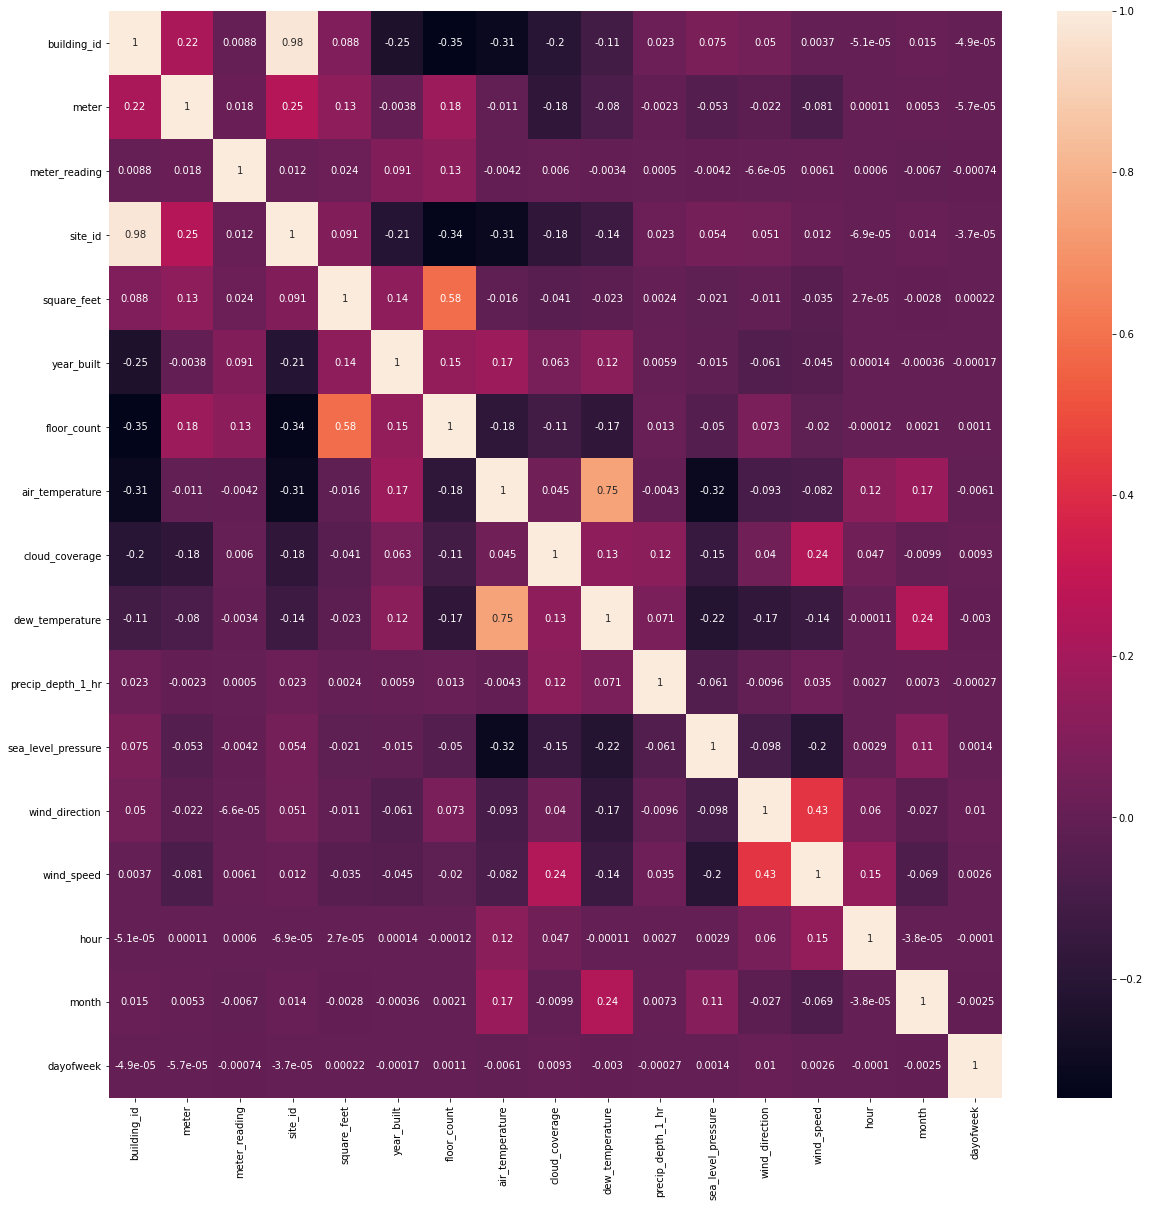

In [ ]:
#df = df[].drop()
corrMatrix = df.corr()

import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
sn.heatmap(corrMatrix, annot=True)
plt.show()

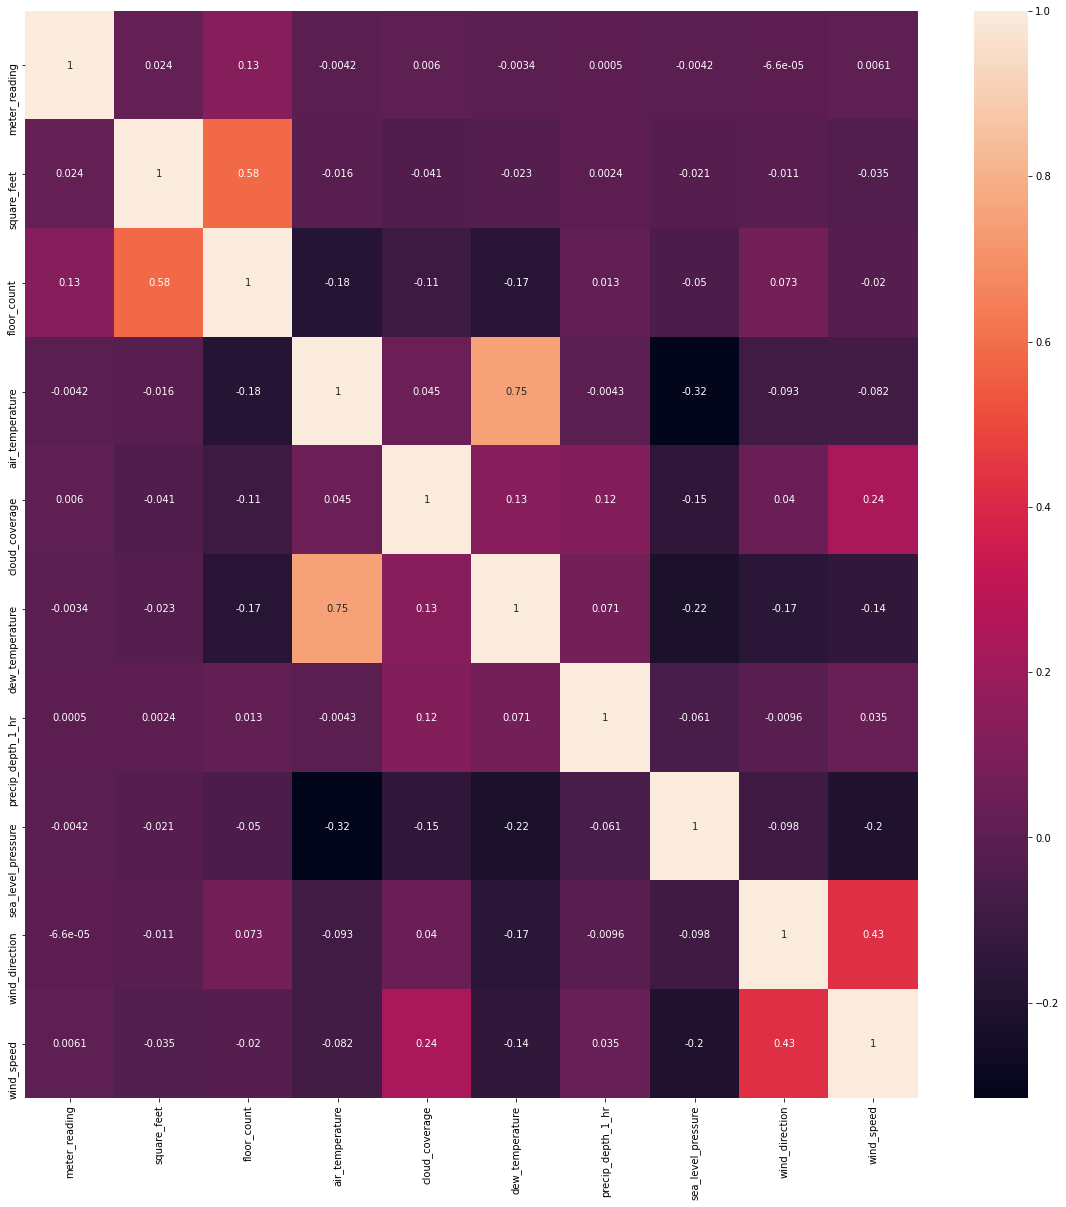

In [ ]:
#temp_df = pd.get_dummies(df,columns = ['primary_use'])
#temp_df_2 = temp_df.drop(columns=["site_id", "building_id", "year_built", "floor_count"])
#corrMatrix = temp_df_2.corr()
temp_df_2 = df.drop(columns=["site_id", "building_id", "meter", "year_built", "hour", "month", "dayofweek"])
corrMatrix = temp_df_2.corr()
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
sn.heatmap(corrMatrix, annot=True)
plt.show()

plot- day of week

In [ ]:
#fig, ax = plt.subplots(figsize=(15,7))
#df_plot.groupby(['dayofweek']).mean()['meter_reading'].plot(ax=ax)
temp_df_2 = df.groupby(['dayofweek'])['meter_reading'].agg(['mean']).reset_index()

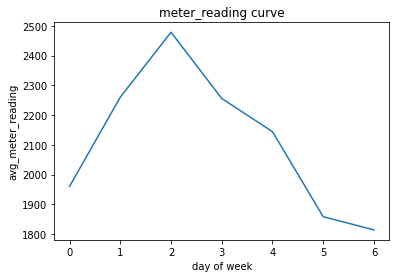

In [ ]:
plt.figure()
plt.plot(temp_df_2['dayofweek'], temp_df_2["mean"] )
plt.title("meter_reading curve")
plt.xlabel("day of week")
plt.ylabel("avg_meter_reading")
plt.show()